In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, plot_roc_curve

In [2]:
data = pd.read_csv("heart.csv")
data.head()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


In [3]:
data.isnull().sum()

age                    0
sex                    0
chest pain type        0
resting bp s           0
cholesterol            0
fasting blood sugar    0
resting ecg            0
max heart rate         0
exercise angina        0
oldpeak                0
ST slope               0
target                 0
dtype: int64

In [4]:
data.head()


,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


In [5]:
def outlier_thresholds(dataframe, col_name, q1=0.10, q3=0.90):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [6]:
def check_outlier(dataframe, col_name, q1=0.10, q3=0.90):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [7]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [8]:
cat_cols, num_cols, cat_but_car = grab_col_names(data)

for col in num_cols:
    print(col, check_outlier(data, col))

Observations: 1190
Variables: 12
cat_cols: 7
num_cols: 5
cat_but_car: 0
num_but_cat: 7
age False
resting bp s True
cholesterol False
max heart rate False
oldpeak False


In [9]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [10]:
for col in num_cols:
    replace_with_thresholds(data, col)

In [11]:
for col in num_cols:
    print(col, check_outlier(data, col))

age False
resting bp s False
cholesterol False
max heart rate False
oldpeak False


In [12]:
data.isnull().values.any()

False

In [13]:
data.corr()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
age,1.000000,0.015096,0.149055,0.260740,-0.046472,0.178923,0.194595,-0.368676,0.188095,0.245093,0.237749,0.262029
sex,0.015096,1.000000,0.138405,-0.005536,-0.208441,0.110961,-0.022225,-0.181837,0.194380,0.096390,0.127913,0.311267
chest pain type,0.149055,0.138405,1.000000,0.009131,-0.109396,0.076492,0.035705,-0.337491,0.403428,0.224106,0.276949,0.460127
resting bp s,0.260740,-0.005536,0.009131,1.000000,0.096468,0.088280,0.095493,-0.101409,0.142589,0.178964,0.091441,0.124398
cholesterol,-0.046472,-0.208441,-0.109396,0.096468,1.000000,-0.239778,0.150879,0.238028,-0.033261,0.057451,-0.100053,-0.198366
fasting blood sugar,0.178923,0.110961,0.076492,0.088280,-0.239778,1.000000,0.032124,-0.118689,0.053053,0.031193,0.145902,0.216695
resting ecg,0.194595,-0.022225,0.035705,0.095493,0.150879,0.032124,1.000000,0.058812,0.037821,0.126023,0.093629,0.073059
max heart rate,-0.368676,-0.181837,-0.337491,-0.101409,0.238028,-0.118689,0.058812,1.000000,-0.377691,-0.183688,-0.350750,-0.413278
exercise angina,0.188095,0.194380,0.403428,0.142589,-0.033261,0.053053,0.037821,-0.377691,1.000000,0.370772,0.393408,0.481467
oldpeak,0.245093,0.096390,0.224106,0.178964,0.057451,0.031193,0.126023,-0.183688,0.370772,1.000000,0.524639,0.398385


In [14]:

import seaborn as sns

<AxesSubplot:>

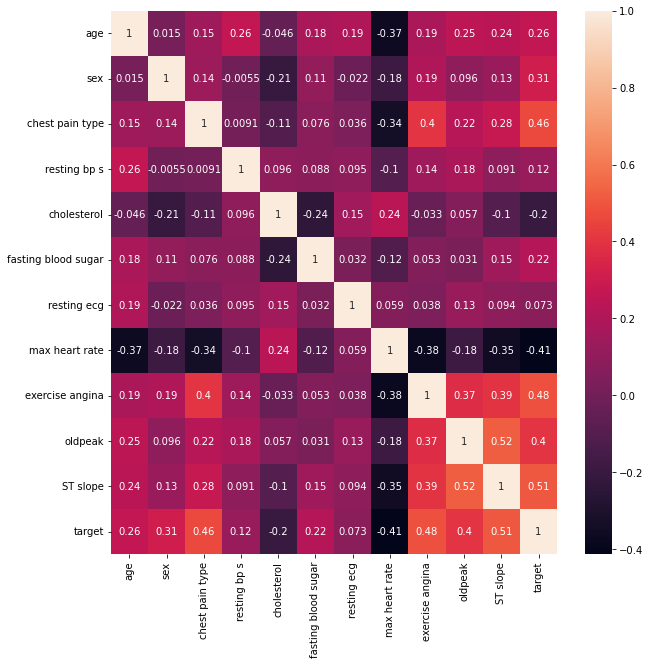

In [15]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(), annot = True)

In [16]:
X = data.iloc[:,:-1]
y = data['target']

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

In [19]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=20)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=20)

In [21]:
from sklearn.model_selection import cross_val_score
#LINEAR KERNAL
from sklearn.svm import SVC
svm_linear = SVC(kernel='linear', C=0.01,gamma='auto')
svm_linear.fit(X_train, y_train)
print("Accuracy:", svm_linear.score(X_train, y_train))

Accuracy: 0.8203781512605042


In [22]:
from sklearn.metrics import accuracy_score

In [23]:
print(accuracy_score(y_test, svm_linear.predict(X_test))*100)

84.45378151260505


In [89]:
X_test[:10]

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope
896,53,1,4,140,203.0,1,2,155,1,3.1,3
1041,64,1,4,120,246.0,0,2,96,1,2.2,3
937,41,0,2,105,198.0,0,0,168,0,0.0,1
87,53,0,2,140,216.0,0,0,142,1,2.0,2
345,51,1,4,120,0.0,1,0,104,0,0.0,2
520,63,1,4,96,305.0,0,1,121,1,1.0,1
74,55,1,4,140,268.0,0,0,128,1,1.5,2
440,74,1,3,138,0.0,0,0,116,0,0.2,1
274,55,1,3,120,220.0,0,2,134,0,0.0,1
335,51,1,4,130,0.0,1,0,170,0,-0.7,1


In [24]:
y_pred = svm_linear.predict(X_test)

y_pred

array([1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1], dtype=int64)

In [91]:

model.predict(X_test[:1])

array([1], dtype=int64)

In [25]:
from sklearn.metrics import accuracy_score

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score: 0.8445


In [26]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[ 90,  14],
       [ 23, 111]], dtype=int64)

In [81]:
from sklearn.metrics import accuracy_score

In [83]:
print(f"Accuracy of model is {round(accuracy_score(y_test, y_pred)*100, 2)}%")

Accuracy of model is 93.7%


In [85]:
import pickle
pickle.dump(model, open('one.pkl', 'wb'))

C:\Users\Satwika Balivada\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


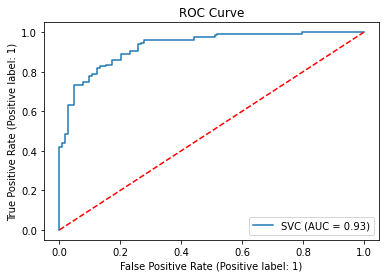

In [29]:
plot_roc_curve(svm_linear, X_test, y_test)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()